## Imports

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import polars as pl
from pathlib import Path
import subprocess

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm

## Configuration and Data Download

In [2]:
DORADO_FILE = Path('../Exemplar_Data/parquet_files/Dorado_filtered_20_20_a.parquet')

DATA_URLS = {
    'glori1': 'https://static-content.springer.com/esm/art%3A10.1038%2Fs41592-025-02680-9/MediaObjects/41592_2025_2680_MOESM5_ESM.xlsb',
    'glori2': 'https://static-content.springer.com/esm/art%3A10.1038%2Fs41592-025-02680-9/MediaObjects/41592_2025_2680_MOESM3_ESM.xlsb'
}

DATA_DIR = Path("../Exemplar_Data/orthogonal_data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

for name, url in DATA_URLS.items():
    output_file = DATA_DIR / Path(url).name
    if not output_file.exists():
        subprocess.run(['wget', '-q', '-O', str(output_file), url], check=True)

M6A_GLORI1_NEW = DATA_DIR / "41592_2025_2680_MOESM5_ESM.xlsb"
M6A_GLORI2_FILE = DATA_DIR / "41592_2025_2680_MOESM3_ESM.xlsb"

## Data Loading

In [3]:
from typing import Union, Any

class OrthogonalDataloader:
    def __init__(self, file_path: Union[Path, str]) -> None:
        self.file_path = Path(file_path)
        if not self.file_path.is_file():
            raise FileNotFoundError(f"File not found: '{self.file_path}'")

    def load_data(self, **kwargs: Any) -> Union[pd.DataFrame, dict, Any]:
        suffixes = self.file_path.suffixes
        
        try:
            if '.xlsb' in suffixes:
                if 'sheet_name' not in kwargs:
                    kwargs['sheet_name'] = None
                engine = 'pyxlsb'
                return pd.read_excel(self.file_path, engine=engine, **kwargs)
            else:
                raise ValueError(f"Unsupported file type: {''.join(suffixes)}")
        
        except Exception as e:
            print(f"Failed to load {self.file_path.name}: {e}")
            return None

## Load all data

In [4]:
hek293_m6a_drs = pl.read_parquet(DORADO_FILE)

loader = OrthogonalDataloader(M6A_GLORI1_NEW)
glori1_raw = loader.load_data()

if isinstance(glori1_raw, dict):
    new_glori1_df = None
    for sheet_name, df in glori1_raw.items():
        if '10ng' in sheet_name:
            new_glori1_df = df
            break
    if new_glori1_df is None:
        raise ValueError("Could not find GLORI-1 sheet with '10ng' in name")
    glori1_raw = new_glori1_df

def process_new_glori1(df):
    df = df.copy()
    if 'm6A_level_mean' in df.columns:
        return df
    df['m6A_level_rep1_pct'] = df['m6A_level_rep1 (%)']
    df['m6A_level_rep2_pct'] = df['m6A_level_rep2 (%)']
    df['m6A_level_rep3_pct'] = df['m6A_level_rep3 (%)']
    df['m6A_level_mean'] = (df['m6A_level_rep1_pct'] + df['m6A_level_rep2_pct'] + df['m6A_level_rep3_pct']) / 3
    return df

new_glori1 = process_new_glori1(glori1_raw)

loader = OrthogonalDataloader(M6A_GLORI2_FILE)
glori2_raw = loader.load_data()

def process_glori2_10ng(sheets_dict):
    target_df = None
    for sheet_name, df in sheets_dict.items():
        if '10ng' in sheet_name and ('mRNA_input' in sheet_name or 'ng_mRNA' in sheet_name):
            target_df = df.copy()
            break
    
    if target_df is None:
        raise ValueError("Could not find 10ng GLORI-2 sheet")
    
    m6a_cols = [col for col in target_df.columns if 'm6A_level' in col and col != 'm6A_level_mean']
    
    if m6a_cols:
        target_df['m6A_level_mean'] = target_df[m6a_cols].mean(axis=1)
    
    return target_df

glori2_10ng = process_glori2_10ng(glori2_raw)
combined_glori_2 = glori2_10ng


## Create GLORI Union

In [5]:
def create_glori_union_values(new_glori1, combined_glori_2):
    glori1_clean = new_glori1.copy()
    glori1_clean['Chr'] = glori1_clean['Chr'].astype(str)
    glori1_clean['Site'] = pd.to_numeric(glori1_clean['Site'], errors='coerce').astype('int64')
    glori1_clean['m6A_level_mean'] = pd.to_numeric(glori1_clean['m6A_level_mean'], errors='coerce')
    glori1_clean = glori1_clean.dropna(subset=['Site', 'm6A_level_mean'])
    
    glori1_pl = pl.from_pandas(glori1_clean[['Chr', 'Site', 'm6A_level_mean']]).with_columns([
        (pl.col('Chr').cast(pl.Utf8) + '_' + pl.col('Site').cast(pl.Int64).cast(pl.Utf8)).alias('site_id')
    ]).select(['site_id', 'm6A_level_mean'])
    
    glori2_clean = combined_glori_2.copy()
    glori2_clean['Chr'] = glori2_clean['Chr'].astype(str)
    glori2_clean['Site'] = pd.to_numeric(glori2_clean['Site'], errors='coerce').astype('int64')
    glori2_clean['m6A_level_mean'] = pd.to_numeric(glori2_clean['m6A_level_mean'], errors='coerce')
    glori2_clean = glori2_clean.dropna(subset=['Site', 'm6A_level_mean'])
    
    glori2_pl = pl.from_pandas(glori2_clean[['Chr', 'Site', 'm6A_level_mean']]).with_columns([
        (pl.col('Chr').cast(pl.Utf8) + '_' + pl.col('Site').cast(pl.Int64).cast(pl.Utf8)).alias('site_id')
    ]).select(['site_id', 'm6A_level_mean'])
    
    glori1_prep = glori1_pl.select([pl.col('site_id'), pl.col('m6A_level_mean').alias('value')])
    glori2_prep = glori2_pl.select([pl.col('site_id'), pl.col('m6A_level_mean').alias('value')])
    all_glori = pl.concat([glori1_prep, glori2_prep])
    
    union_df = all_glori.group_by('site_id').agg([
        pl.col('value').mean().alias('m6A_combined')
    ]).select(['site_id', 'm6A_combined'])
    
    return union_df

glori_union = create_glori_union_values(new_glori1, glori2_10ng)

## Get DRS Values

In [6]:
def get_drs_values(df: pl.DataFrame) -> pl.DataFrame:
    df_filtered = df.filter((pl.col('IVT_Adjusted_Mod_Percent') >= 20) & (pl.col('Score') >= 20))
    
    sample_chr = df_filtered['Chromosome'][0] if len(df_filtered) > 0 else None
    if sample_chr and not str(sample_chr).startswith('chr'):
        df_filtered = df_filtered.with_columns([
            ('chr' + pl.col('Chromosome').cast(pl.Utf8) + '_' + 
             pl.col('End').cast(pl.Int64).cast(pl.Utf8)).alias('site_id')
        ])
    else:
        df_filtered = df_filtered.with_columns([
            (pl.col('Chromosome').cast(pl.Utf8) + '_' + 
             pl.col('End').cast(pl.Int64).cast(pl.Utf8)).alias('site_id')
        ])
    
    return df_filtered.select(['site_id', 'IVT_Adjusted_Mod_Percent'])

drs_values = get_drs_values(hek293_m6a_drs)

## Plotting

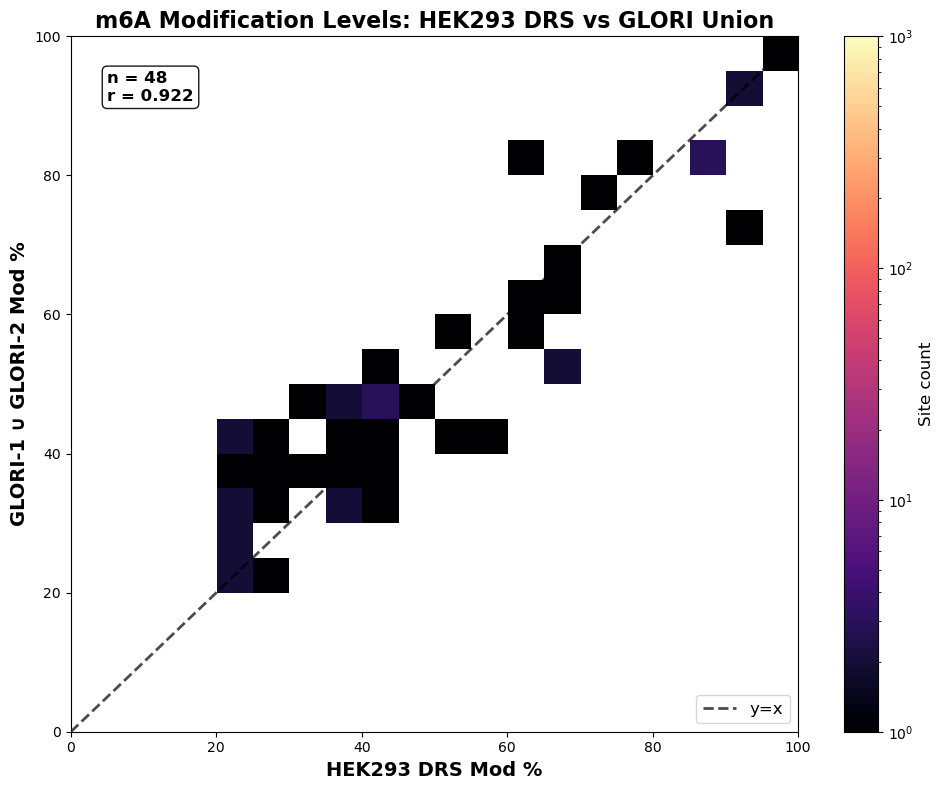

Overlapping sites: 48
Correlation: 0.922


In [7]:
merged = drs_values.join(glori_union, on='site_id', how='inner')

drs_vals = merged['IVT_Adjusted_Mod_Percent'].to_numpy()
glori_vals = merged['m6A_combined'].to_numpy()

correlation = np.corrcoef(drs_vals, glori_vals)[0, 1]

bandwidth = 5
bins = np.arange(0, 100 + bandwidth, bandwidth)
hist, xedges, yedges = np.histogram2d(drs_vals, glori_vals, bins=bins)

fig, ax = plt.subplots(figsize=(10, 8))

im = ax.imshow(hist.T, norm=LogNorm(vmin=1, vmax=10**3),
               origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               aspect='auto', cmap='magma', interpolation='nearest')

cbar = plt.colorbar(im, ax=ax, ticks=np.logspace(0, 3, 4))
cbar.set_ticklabels(['$10^0$', '$10^1$', '$10^2$', '$10^3$'])
cbar.set_label('Site count', fontsize=12)

ax.set_xlabel('HEK293 DRS Mod %', fontsize=14, fontweight='bold')
ax.set_ylabel('GLORI-1 ∪ GLORI-2 Mod %', fontsize=14, fontweight='bold')
ax.set_title('m6A Modification Levels: HEK293 DRS vs GLORI Union', 
             fontweight='bold', fontsize=16)
ax.plot([0, 100], [0, 100], 'k--', linewidth=2, alpha=0.7, label='y=x')

stats_text = f'n = {len(merged):,}\nr = {correlation:.3f}'
ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
        fontsize=12, verticalalignment='top', fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

ax.legend(loc='lower right', fontsize=12)

plt.tight_layout()
plt.show()

print(f"Overlapping sites: {len(merged):,}")
print(f"Correlation: {correlation:.3f}")